# Looking at ZBP and CBP data for Cali

David Tersegno

4/17/22

These are the census County Business Patterns and Zipcode Business Patters data. We'd like to split this up into regions that can be compared with the CAES data sets.

These have individual businesses registered, with info on employee counts, total payroll (county data), and business type by census NAICS. North American Industry Classification/Codes System.

We are interested in businesses of code `493110	General Warehousing and Storage`, as well as any other `49////` business, and perhaps others afterwards.

---


In [2]:
#import librarbies
import pandas as pd
import numpy as np
import os

### ZBP 2019

In [3]:
#import data
os.listdir('../raw_data/cbp19/')

['cbp19cd.xlsx',
 'cbp19co.zip',
 'cbp19csa.zip',
 'cbp19msa.zip',
 'cbp19pr_ia_co.zip',
 'cbp19pr_ia_st.zip',
 'cbp19st.zip',
 'cbp19us.zip',
 'zbp19detail.txt',
 'zbp19detail.zip',
 'zbp19totals.zip']

In [7]:
zbp19_path = '../raw_data/cbp19/zbp19detail.txt'

#import as a dataframe. The encoding argument is necessary to get it to not yell at you.
z19 = pd.read_csv(zbp19_path, encoding = 'ISO-8859-1')

In [10]:
z19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2881311 entries, 0 to 2881310
Data columns (total 16 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   zip       int64 
 1   name      object
 2   naics     object
 3   est       int64 
 4   n<5       object
 5   n5_9      object
 6   n10_19    object
 7   n20_49    object
 8   n50_99    object
 9   n100_249  object
 10  n250_499  object
 11  n500_999  object
 12  n1000     object
 13  city      object
 14  stabbr    object
 15  cty_name  object
dtypes: int64(2), object(14)
memory usage: 351.7+ MB


In [11]:
z19['est'].describe()

count    2.881311e+06
mean     1.415095e+01
std      5.912356e+01
min      3.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      1.100000e+01
max      3.101000e+04
Name: est, dtype: float64

In [21]:
z19.isna().sum()

zip         0
name        0
naics       0
est         0
n<5         0
n5_9        0
n10_19      0
n20_49      0
n50_99      0
n100_249    0
n250_499    0
n500_999    0
n1000       0
city        0
stabbr      0
cty_name    0
dtype: int64

No nulls anywhere. Lovely.

In [12]:
z19.head()

,zip,name,naics,est,n<5,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,city,stabbr,cty_name
0,501,"HOLTSVILLE, NY",------,3,N,N,N,N,N,N,N,N,N,HOLTSVILLE,NY,SUFFOLK
1,1001,"AGAWAM, MA",------,473,217,89,69,60,23,13,N,N,N,AGAWAM,MA,HAMPDEN
2,1001,"AGAWAM, MA",23----,49,30,7,4,6,N,N,N,N,N,AGAWAM,MA,HAMPDEN
3,1001,"AGAWAM, MA",236///,5,N,N,N,N,N,N,N,N,N,AGAWAM,MA,HAMPDEN
4,1001,"AGAWAM, MA",2361//,4,N,N,N,N,N,N,N,N,N,AGAWAM,MA,HAMPDEN


The most attractive thing about this data for our project is that it's pretty simple. A location (zip, city, state, county), and NAICS code, and a number of establishments falling into an employment size category.


It LOOKS like that last bit is true. Let's verify --- `est` would be the sum of the n... columns.

First turn those Ns to zeros, and the entries to ints.

In [18]:
#coverts a series of string numbers to ints, along with converting 'N' -> 0
def convert_n_column(series):
    return series.apply(lambda entry: 0 if entry == 'N' else int(entry)) 

#do this for the whole dataframe
# def convert_n_columns(dataframe):
#     return None

for column in z19.columns:
    if column[0] == 'n' and column != 'name' and column != 'naics':
        print(f'working on {column}')
        z19[column] = convert_n_column(z19[column])

working on n<5
working on n5_9
working on n10_19
working on n20_49
working on n50_99
working on n100_249
working on n250_499
working on n500_999
working on n1000


In [20]:
z19.head()

,zip,name,naics,est,n<5,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,city,stabbr,cty_name
0,501,"HOLTSVILLE, NY",------,3,0,0,0,0,0,0,0,0,0,HOLTSVILLE,NY,SUFFOLK
1,1001,"AGAWAM, MA",------,473,217,89,69,60,23,13,0,0,0,AGAWAM,MA,HAMPDEN
2,1001,"AGAWAM, MA",23----,49,30,7,4,6,0,0,0,0,0,AGAWAM,MA,HAMPDEN
3,1001,"AGAWAM, MA",236///,5,0,0,0,0,0,0,0,0,0,AGAWAM,MA,HAMPDEN
4,1001,"AGAWAM, MA",2361//,4,0,0,0,0,0,0,0,0,0,AGAWAM,MA,HAMPDEN


In [89]:
#isolate the n... cols. I probably should have done this before. be careful blindly applying [4:-4] to other sets.
#these n_cols are the number of establishments employing a range of employees. This could be a very rough measure of
#the activity of the business, which could be roughly related to the pollution output.

n_cols = z19.columns[4:-4]
n_cols

Index(['n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000'],
      dtype='object')

In [46]:
%%time
#this checker takes a while. let's just check for warehouse types.
z19['is_warehouse_type'] = z19.apply(lambda x: x['naics'].startswith('49'), axis = 1)

Wall time: 27.9 s


In [67]:
z19_CA = z19[z19['stabbr']=="CA"]

In [92]:
z19_CA_warehouses = z19_CA[z19_CA['is_warehouse_type']].copy()

array([[<AxesSubplot:title={'center':'est'}>]], dtype=object)

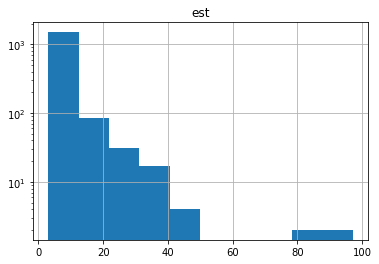

In [93]:
z19_CA_warehouses.hist('est', log = True)

These are the ~1600 entries in CA whose naics code starts with '49'.

What are these businesses with more than 50 establishments?

In [94]:
z19_CA_warehouses[z19_CA_warehouses['est']>50]

,zip,name,naics,est,n<5,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,city,stabbr,cty_name,is_warehouse_type
2527524,91761,"ONTARIO, CA",493///,97,17,10,19,22,18,8,0,0,0,ONTARIO,CA,SAN BERNARDINO,True
2527525,91761,"ONTARIO, CA",4931//,97,17,10,19,22,18,8,0,0,0,ONTARIO,CA,SAN BERNARDINO,True
2527526,91761,"ONTARIO, CA",49311/,84,13,9,14,21,18,6,0,0,0,ONTARIO,CA,SAN BERNARDINO,True
2527527,91761,"ONTARIO, CA",493110,84,13,9,14,21,18,6,0,0,0,ONTARIO,CA,SAN BERNARDINO,True


Boom. A few hundred locations in Ontario, San Bernardino County, owned by a couple places. (Ontario, CA is a very confusing name, by the way).

Unfortunately, this throws up another problem --- it may very well be that these four entries correspond to only two real businesses. Or perhaps even one, if the naics codes with /s in them are sums of those with more specific codes. (The 84 in the 49311/ group might be a subset of the 97 in the 493/// group). Otherwise it's an incredible coincidence that the numbers in the bottom two rows are
1. smaller than their counterparts in the top rows and
2. the paired up rows have the same numbers for all these employment categories.

In [95]:
#checks if the number of establishments value is the sum of the n_cols values.
def is_employee_sum_ok(row):
    return row['est'] == row[n_cols].sum()

In [96]:
%%time
z19_CA_warehouses['employee_sum_ok'] = z19_CA_warehouses.apply(is_employee_sum_ok, axis=1)

Wall time: 471 ms


In [97]:
z19_CA_warehouses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1640 entries, 2443850 to 2747435
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   zip                1640 non-null   int64 
 1   name               1640 non-null   object
 2   naics              1640 non-null   object
 3   est                1640 non-null   int64 
 4   n<5                1640 non-null   int64 
 5   n5_9               1640 non-null   int64 
 6   n10_19             1640 non-null   int64 
 7   n20_49             1640 non-null   int64 
 8   n50_99             1640 non-null   int64 
 9   n100_249           1640 non-null   int64 
 10  n250_499           1640 non-null   int64 
 11  n500_999           1640 non-null   int64 
 12  n1000              1640 non-null   int64 
 13  city               1640 non-null   object
 14  stabbr             1640 non-null   object
 15  cty_name           1640 non-null   object
 16  is_warehouse_type  1640 non-null 

In [98]:
n_cols

Index(['n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99', 'n100_249', 'n250_499',
       'n500_999', 'n1000'],
      dtype='object')

In [102]:
z19_CA_warehouses['employee_sum_ok'].sum()

84

Only 84 of the ~1600 entries have n_col sums the same as est.

In [119]:
#looking at them sorted by naics.
z19_CA_warehouses.groupby('naics').mean()

,zip,est,n<5,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,is_warehouse_type,employee_sum_ok
naics,,,,,,,,,,,,,
492///,92828.004444,5.248889,1.408889,0.186667,0.080000,0.048889,0.026667,0.088889,0.017778,0.0,0.013333,1.0,0.075556
4921//,92854.523438,5.101562,1.257812,0.070312,0.046875,0.031250,0.023438,0.101562,0.031250,0.0,0.023438,1.0,0.054688
49211/,92854.523438,5.101562,1.257812,0.070312,0.046875,0.031250,0.023438,0.101562,0.031250,0.0,0.023438,1.0,0.054688
492110,92854.523438,5.101562,1.257812,0.070312,0.046875,0.031250,0.023438,0.101562,0.031250,0.0,0.023438,1.0,0.054688
4922//,93218.962264,3.660377,0.716981,0.056604,0.056604,0.056604,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.075472
49221/,93218.962264,3.660377,0.716981,0.056604,0.056604,0.056604,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.075472
492210,93218.962264,3.660377,0.716981,0.056604,0.056604,0.056604,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.075472
493///,93109.796380,8.085973,1.533937,0.638009,0.583710,0.850679,0.425339,0.153846,0.027149,0.0,0.013575,1.0,0.045249
4931//,93109.796380,8.085973,1.533937,0.638009,0.583710,0.850679,0.425339,0.153846,0.027149,0.0,0.013575,1.0,0.045249


In [114]:
# this set may be loaded with duplicates, with rows summarized by naics type. But, the est values aren't
# necessarily the same as the num of employee-size-divided establishments.

#I also don't think it's a coincidence that the sum columns are the same for a type as their parent rows --- I am
# strongly suspecting that any NAICS column ending with '/' is an aggregate of the ones under it.

# what this means is, if we're just counting businesses, we need to ONLY count those with no '/'s in their naic, or only 
# count those at the same level (those with one '/', or only two '//', etc.). There aren't a whole lot of levels here due
# to how these are classified: adding up the 493190s is the same as adding up the 49319/s. But we shouldn't count
# them both.

# I'm thinking the best way to count is to sort by zip or county, and just grab the ones whose code is at the lowest
# level in the hierarchy --- just those codes without any '/'s.

In [123]:
z19_CA_warehouses['not_ends_in_/'] = z19_CA_warehouses.apply(lambda row: row['naics'][-1] != '/', axis = 1)

In [127]:
z19_CA_warehouses_lowlevel = z19_CA_warehouses[z19_CA_warehouses['not_ends_in_/']]
z19_CA_warehouses_lowlevel

,zip,name,naics,est,n<5,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,city,stabbr,cty_name,is_warehouse_type,employee_sum_ok,ends_in_/,not_ends_in_/
2444669,90005,"LOS ANGELES, CA",492110,4,4,0,0,0,0,0,0,0,0,LOS ANGELES,CA,LOS ANGELES,True,True,False,True
2447653,90015,"LOS ANGELES, CA",492110,4,0,0,0,0,0,0,0,0,0,LOS ANGELES,CA,LOS ANGELES,True,False,False,True
2449654,90021,"LOS ANGELES, CA",492110,3,0,0,0,0,0,0,0,0,0,LOS ANGELES,CA,LOS ANGELES,True,False,False,True
2449658,90021,"LOS ANGELES, CA",493110,3,0,0,0,0,0,0,0,0,0,LOS ANGELES,CA,LOS ANGELES,True,False,False,True
2449660,90021,"LOS ANGELES, CA",493120,4,0,0,0,0,0,0,0,0,0,LOS ANGELES,CA,LOS ANGELES,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740239,95838,"SACRAMENTO, CA",493110,3,0,0,0,0,0,0,0,0,0,SACRAMENTO,CA,SACRAMENTO,True,False,False,True
2742453,95945,"GRASS VALLEY, CA",493110,3,0,0,0,0,0,0,0,0,0,GRASS VALLEY,CA,NEVADA,True,False,False,True
2744463,95987,"WILLIAMS, CA",493110,7,5,0,0,0,0,0,0,0,0,WILLIAMS,CA,COLUSA,True,False,False,True
2745742,96002,"REDDING, CA",492110,3,0,0,0,0,0,0,0,0,0,REDDING,CA,SHASTA,True,False,False,True


In [132]:
z19_CA_warehouses_lowlevel.groupby(by = 'cty_name').mean().sort_values(by = 'est')

,zip,est,n<5,n5_9,n10_19,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,is_warehouse_type,employee_sum_ok,ends_in_/,not_ends_in_/
cty_name,,,,,,,,,,,,,,,
SANTA BARBARA,93455.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,1.0
NEVADA,95945.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,1.0
SHASTA,96002.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,1.0
INYO,93514.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,1.0
KINGS,93212.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,1.0
HUMBOLDT,95501.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,1.0
KERN,93277.900000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,1.0
PLACER,95690.750000,3.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.250000,0.0,1.0
SONOMA,95336.666667,3.833333,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.0,1.0


The ones at the bottom are the ones with businesses with the most number of establishments. This isn't a total, but it does show that single businesses in SB, Riverside, Napa, Colusa, LA, Ventura counties tend to own more establishments than those in other counties.